In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import interp1d

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import tomso.gyre as gyre
import tomso.fgong as fgong

from uncertainties import ufloat, unumpy

import tomso

import corner

from tqdm import tqdm_notebook as tqdm

In [2]:
import os
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('thinfig')

In [3]:
red = "#CA0020"
orange = "#F97100" 
blue = "#0571b0"

In [4]:
DF = pd.read_table('mcmc/MCMC_save/output.dat')
DF

,Y,Z,a,t,r1,r2,r3,r4,r5,Fe_H,...,r13_18,r13_19,r13_20,r13_21,r13_22,r13_23,r13_24,r13_25,r13_26,chi2
0,0.275653,0.018480,1.914749,4.568094,1.007102,1.028761,0.983109,1.034036,1.041354,0.000480,...,0.127431,0.123798,0.120708,0.117079,0.113717,0.110545,0.107102,0.104114,0.100974,2.384452
1,0.275582,0.018560,1.908960,4.572153,0.991791,1.083110,1.057019,0.979475,0.963539,0.001952,...,0.127478,0.123863,0.120778,0.117139,0.113794,0.110610,0.107167,0.104183,0.101027,2.385148
2,0.276400,0.018676,1.917523,4.574334,1.007864,1.041474,0.980694,1.046266,1.108359,0.005726,...,0.127325,0.123678,0.120589,0.116975,0.113596,0.110440,0.106995,0.104002,0.100877,19.610811
3,0.274512,0.018260,1.911211,4.574562,1.014448,0.939659,0.929022,1.092993,0.999631,-0.005423,...,0.127477,0.123842,0.120746,0.117110,0.113750,0.110572,0.107128,0.104143,0.100998,7.914481
4,0.274947,0.018457,1.905294,4.576506,0.985387,0.973641,1.021438,0.951300,1.036610,-0.001158,...,0.127511,0.123911,0.120820,0.117171,0.113838,0.110636,0.107196,0.104212,0.101040,7.055028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95531,0.274405,0.018262,1.905409,4.571088,0.996656,0.982528,1.089198,1.030346,1.126533,-0.005851,...,0.127452,0.123826,0.120720,0.117056,0.113704,0.110495,0.107040,0.104045,0.100868,42.316475
95532,0.276344,0.018660,1.914017,4.563487,0.997430,1.070705,0.988141,1.017067,1.076528,0.004995,...,0.127488,0.123870,0.120793,0.117165,0.113817,0.110647,0.107206,0.104228,0.101084,4.951918
95533,0.275476,0.018516,1.910048,4.572811,0.998996,1.013034,1.007636,1.017856,1.045683,0.000998,...,0.127450,0.123825,0.120736,0.117099,0.113746,0.110565,0.107120,0.104135,0.100984,3.147530
95534,0.275269,0.018390,1.913568,4.566731,1.005543,0.938262,0.948399,1.007061,0.876925,-0.002051,...,0.127475,0.123853,0.120761,0.117128,0.113776,0.110595,0.107156,0.104171,0.101024,5.384232


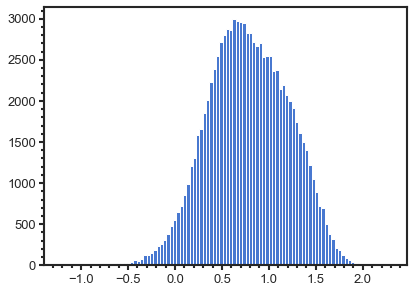

In [5]:
plt.hist(np.log10(DF['chi2']), bins=100);

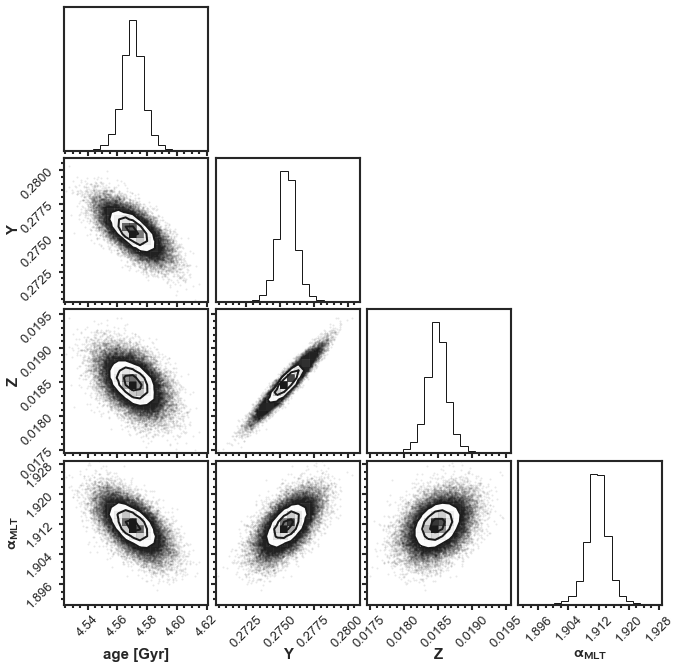

In [32]:
corner.corner(DF[['t', 'Y', 'Z', 'a']],
             labels=[r'age [Gyr]', 'Y', 'Z', r'$\mathbf{\alpha_{MLT}}$']);

In [117]:
X = np.vstack((np.ones(len(DF)), DF['Z'].values, DF['a'].values)).T
Y = DF['Y'].values
coefs = np.linalg.solve(X.T@X, X.T@Y)
coefs

array([0.05417411, 3.83161506, 0.07871689])

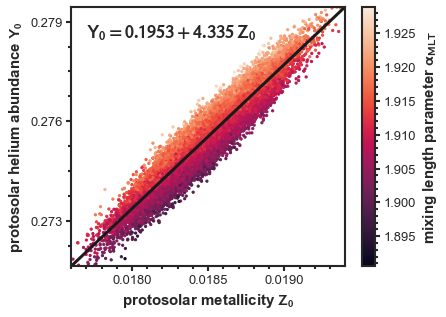

In [144]:
#plt.plot(DF['Z'], DF['Y'], 'k.')
plt.scatter(DF['Z'], DF['Y'], c=DF['a'], s=5)

X = np.vstack((np.ones(len(DF)), DF['Z'].values)).T
Y = DF['Y'].values
coefs = np.linalg.solve(X.T@X, X.T@Y)

zs = np.linspace(0.0175, 0.0195, 10)
plt.plot(zs, zs*coefs[1] + coefs[0], lw=3, c='k')#red)

plt.text(0.0177, 0.2785, r'$\mathbf{Y_0 = 0.1953 + 4.335\; Z_0}$')

plt.ylabel(r'protosolar helium abundance $\mathbf{Y_0}$')
plt.xlabel(r'protosolar metallicity $\mathbf{Z_0}$')
plt.colorbar(label=r'mixing length parameter $\mathbf{\alpha_{MLT}}$')
xlim = [0.0176, 0.0194]
plt.xlim(xlim)
plt.ylim(np.array(xlim)*coefs[1]+coefs[0])
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
#plt.ylim([0.2717, 0.28])
plt.tight_layout()
plt.show()

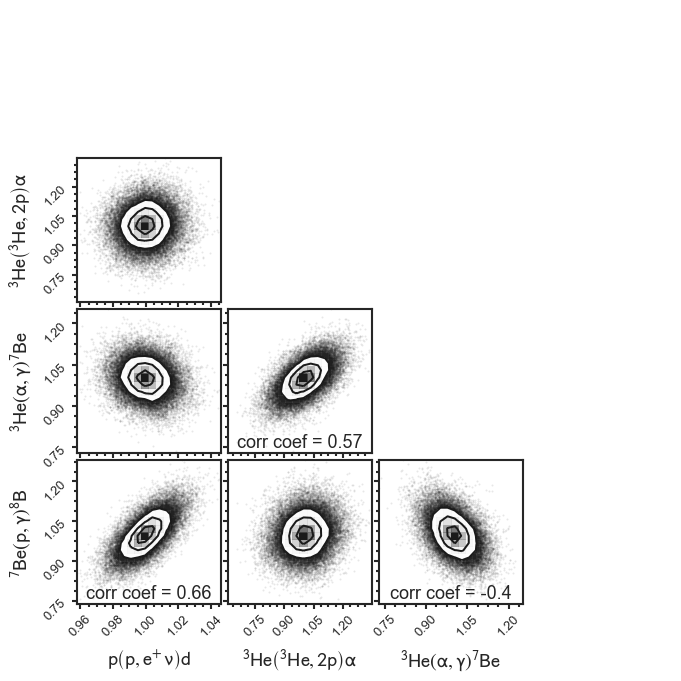

In [219]:
fig = corner.corner(DF[['r1', 'r2', 'r3', 'r4']],
             labels=[r'$\rm{p}\left(\rm{p}, \rm{e}^{+}\,\nu\right)d$', 
                     r'$^3\rm{He}\left(^3\rm{He}, 2\rm{p}\right)\alpha$', 
                     r'$^3\rm{He}\left(\alpha, \gamma\right)^7\rm{Be}$', 
                     r'$^7\rm{Be}(\rm{p}, \gamma)^8\rm{B}$'],
                   label_kwargs={'fontsize': 20})#,
                     #r'$^{14}\rm{N}\left(\rm{p}, \gamma\right)^{15}\rm{O}$'])

axes = np.array(fig.axes).reshape((4,4))

corr = DF[['r1', 'r2', 'r3', 'r4']].corr()

for yi in range(4):
    for xi in range(4):
        ax = axes[yi, xi]
        
        if yi > xi:
            if np.abs(corr.values[yi, xi]) > 0.2:
                print()
                ax.text(0.5, 0.075, 'corr coef = ' + str(corr.values[yi, xi])[:4],
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = ax.transAxes)
        
        if yi != xi:
            continue 
        ax.remove()

plt.savefig('correlations.pdf')

In [257]:
names = {'r1': r'$\rm{p}\left(\rm{p}, \rm{e}^{+}\,\nu\right)d$', 
         'r2': r'$^3\rm{He}\left(^3\rm{He}, 2\rm{p}\right)\alpha$', 
         'r3': r'$^3\rm{He}\left(\alpha, \gamma\right)^7\rm{Be}$', 
         'r4': r'$^7\rm{Be}(\rm{p}, \gamma)^8\rm{B}$',
         'r5': r'$^{14}\rm{N}\left(\rm{p}, \gamma\right)^{15}\rm{O}$',
         'Y': r'$Y_0$',
         'Z': r'$Z_0$',
         'a': r'$\alpha_{MLT}$',
         't': r'age',
         'Fe_H': r'[Fe/H]',
         'R': 'radius',
         'L': 'luminosity',
         'pp': r'$\Phi\left(pp\right)$',
         'pep': r'$\Phi\left(pep\right)$',
         'Be7': r'$\Phi\left(^7Be\right)$',
         'B8': r'$\Phi\left(^8B\right)$'}

DF_ = DF.drop('R', axis=1)
corr = DF_.iloc[:,:15].corr()
corr = corr.rename(columns=names, index=names)
corr

,$Y_0$,$Z_0$,$\alpha_{MLT}$,age,"$\rm{p}\left(\rm{p}, \rm{e}^{+}\,\nu\right)d$","$^3\rm{He}\left(^3\rm{He}, 2\rm{p}\right)\alpha$","$^3\rm{He}\left(\alpha, \gamma\right)^7\rm{Be}$","$^7\rm{Be}(\rm{p}, \gamma)^8\rm{B}$","$^{14}\rm{N}\left(\rm{p}, \gamma\right)^{15}\rm{O}$",[Fe/H],luminosity,$\Phi\left(pp\right)$,$\Phi\left(pep\right)$,$\Phi\left(^7Be\right)$,$\Phi\left(^8B\right)$
$Y_0$,1.000000,0.946765,0.607079,-0.684266,-0.170620,0.056379,-0.033008,-0.217103,0.008189,0.966165,-0.175942,-0.229652,-0.199573,0.104043,0.036941
$Z_0$,0.946765,1.000000,0.360291,-0.470248,-0.380728,0.052771,-0.072762,-0.268158,-0.002805,0.996839,-0.323920,-0.315056,-0.120377,0.109877,0.048987
$\alpha_{MLT}$,0.607079,0.360291,1.000000,-0.605352,0.467282,0.082877,-0.067470,0.143286,0.010335,0.419457,0.285232,0.271288,-0.102779,-0.152464,-0.005687
age,-0.684266,-0.470248,-0.605352,1.000000,-0.219490,-0.034755,-0.057631,0.047072,0.020798,-0.521025,-0.074520,0.019284,0.267759,-0.055626,0.009757
"$\rm{p}\left(\rm{p}, \rm{e}^{+}\,\nu\right)d$",-0.170620,-0.380728,0.467282,-0.219490,1.000000,0.065316,-0.158134,0.663172,-0.047387,-0.312717,-0.085937,0.526001,-0.154686,-0.548695,-0.069659
"$^3\rm{He}\left(^3\rm{He}, 2\rm{p}\right)\alpha$",0.056379,0.052771,0.082877,-0.034755,0.065316,1.000000,0.570605,0.138042,0.016928,0.056410,0.029727,0.196021,0.172612,-0.209864,-0.004367
"$^3\rm{He}\left(\alpha, \gamma\right)^7\rm{Be}$",-0.033008,-0.072762,-0.067470,-0.057631,-0.158134,0.570605,1.000000,-0.426012,-0.078774,-0.073647,0.024409,-0.526764,-0.492369,0.623992,0.013870
"$^7\rm{Be}(\rm{p}, \gamma)^8\rm{B}$",-0.217103,-0.268158,0.143286,0.047072,0.663172,0.138042,-0.426012,1.000000,0.049643,-0.236626,-0.136056,0.674088,0.290030,-0.793470,0.473245
"$^{14}\rm{N}\left(\rm{p}, \gamma\right)^{15}\rm{O}$",0.008189,-0.002805,0.010335,0.020798,-0.047387,0.016928,-0.078774,0.049643,1.000000,-0.004964,0.028461,-0.121444,-0.114679,-0.088400,0.045747
[Fe/H],0.966165,0.996839,0.419457,-0.521025,-0.312717,0.056410,-0.073647,-0.236626,-0.004964,1.000000,-0.322840,-0.291102,-0.147783,0.088169,0.044932


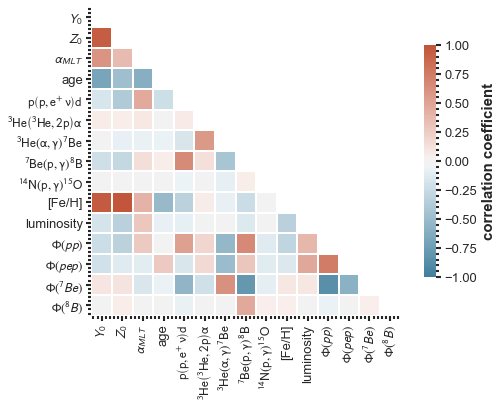

In [262]:
#corr = DF[['r1', 'r2', 'r3', 'r4']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.75, 'label': 'correlation coefficient'})
#plt.figure(figsize=(10,10))
#plt.matshow(corr)
plt.tight_layout()
plt.savefig('allcorrs.pdf')

<AxesSubplot:>

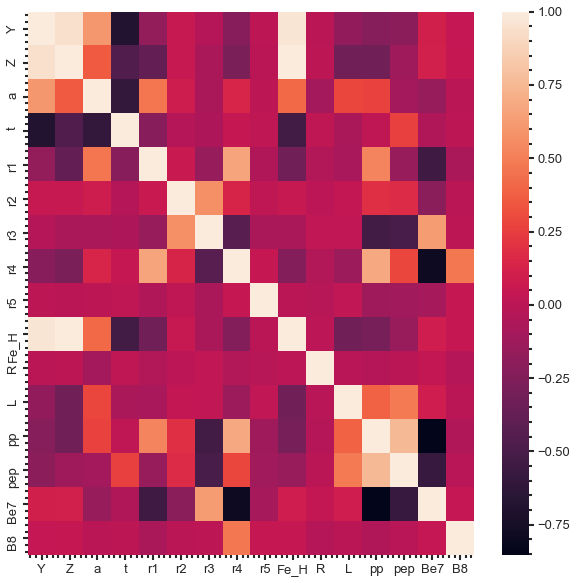

In [166]:
#plt.matshow(np.cov(DF))
plt.figure(figsize=(10,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)